In [27]:
%pylab inline
from pygadgetreader import *
from astropy import units as u
from astropy import constants

Populating the interactive namespace from numpy and matplotlib


In [3]:
font = {'size':13, 'family':'serif'}
matplotlib.rc('font', **font)

In [4]:
path = '../data/MW_models/rc-test/'
I = 'MW3vir_000'
F = 'MW3vir_002'

In [38]:
I_disk = readsnap(path + I, 'pos', 'disk')
F_disk = readsnap(path + F, 'pos', 'disk')
F_diskM = readsnap(path + F, 'mass', 'disk')


I_diskV = readsnap(path + I, 'vel', 'disk')
F_diskV = readsnap(path + F, 'vel', 'disk')

I_diskP = readsnap(path + I, 'pot', 'disk')
F_diskP = readsnap(path + F, 'pot', 'disk')

print (F_diskM[0])

Returning DISK  Positions
Returning DISK  Positions
Returning DISK  Mass
Returning DISK  Velocities
Returning DISK  Velocities
Returning DISK  Potential
Returning DISK  Potential
5.25004e-05


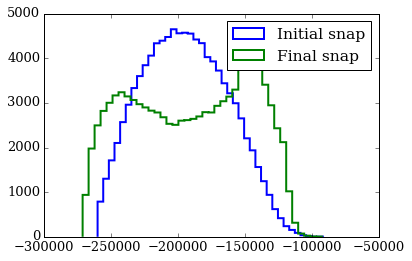

In [6]:
h = hist(I_diskP, bins=40, histtype='step', lw=2, label='Initial snap')
h = hist(F_diskP, bins=40, histtype='step', lw=2, label='Final snap')
legend()

In [7]:
potential1 = np.where((F_diskP < -240000) & (F_diskP > -260000))[0]
potential2 = np.where((F_diskP < -140000) & (F_diskP < -110000))[0]

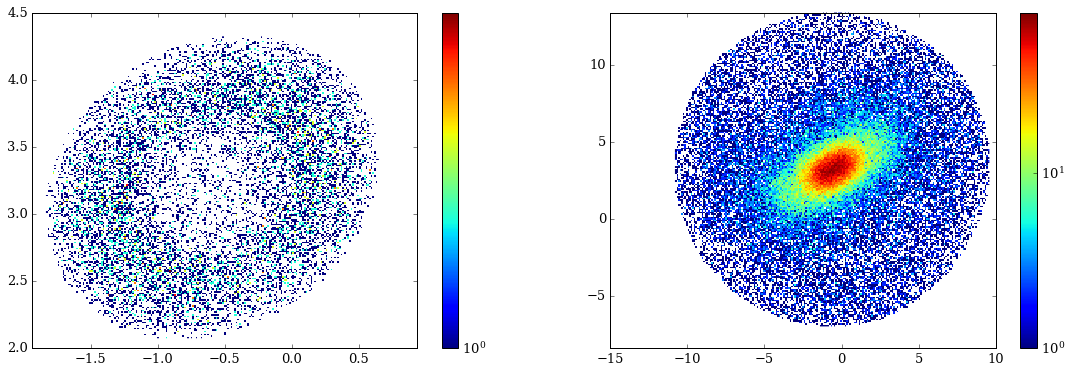

In [8]:
figsize(19, 6)
subplot(1, 2, 1)
HR = hist2d(F_disk[potential1,0], F_disk[potential1,1], bins=200, norm=mpl.colors.LogNorm())
colorbar()
axis('equal')

subplot(1, 2, 2)
MR = hist2d(F_disk[potential2,0], F_disk[potential2,1], bins=200, norm=mpl.colors.LogNorm())
axis('equal')
colorbar()

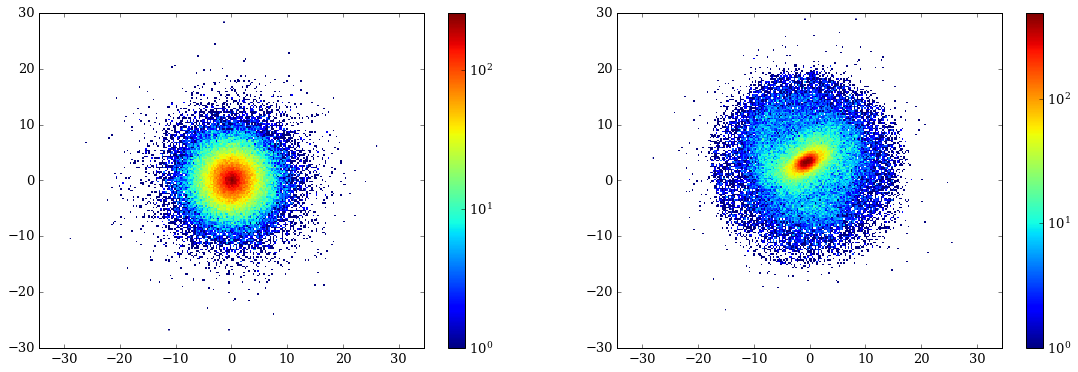

In [9]:
figsize(19, 6)
subplot(1, 2, 1)
HR = hist2d(I_disk[:,0], I_disk[:,1], bins=200, norm=mpl.colors.LogNorm())
colorbar()
axis('equal')

subplot(1, 2, 2)
MR = hist2d(F_disk[:,0], F_disk[:,1], bins=200, norm=mpl.colors.LogNorm())
axis('equal')
colorbar()

savefig('evolved_disk.png', bbox_inches='tight')


In [108]:
def CM_correction(x, y, z, pot):
    CM = np.where(pot == min(pot))[0]
    xc = x - x[CM]
    yc = y - y[CM]
    zc = z - z[CM]
    print x[CM], y[CM], z[CM]
    return xc, yc, zc

def VCM_correction(x, y, z, vx, vy, vz):
    center = np.where((x**2+y**2+z**2)<4.0)[0]
    N = len(center)
    vxcm = sum(vx[center])/N
    vycm = sum(vy[center])/N
    vzcm = sum(vz[center])/N
    print vxcm, vycm, vzcm
    vxc = vx - vxcm
    vyc = vy - vycm
    vzc = vz - vzcm
    return vxc, vyc, vzc

def rot_curve1(x, y, z, vx, vy, vz):
    R = np.linspace(0, 30, 30)
    vc = np.zeros(30)
    for i in range(len(R)-1):
        bin_cut = np.where((np.sqrt(x**2.0 + y**2.0) < R[i+1]) & (np.sqrt(x**2.0 + y**2.0) > R[i]) & (z<0.5) & (z>-0.5))[0]
        vc[i] = average(np.sqrt(vx[bin_cut]**2 + vy[bin_cut]**2))
    return R, vc


def rot_curve2(x, y, z, vx, vy, vz):
    R = np.linspace(0, 30, 30)
    vc = np.zeros(30)
    for i in range(len(R)-1):
        bin_cut = np.where((x < R[i+1]) & ((x) > R[i]) & (z<0.5) & (z>-0.5))[0]
        vc[i] = average(np.sqrt(vx[bin_cut]**2 + vy[bin_cut]**2))
    return R, vc

def rot_curve3(x, y, z):
    R = np.linspace(0.1, 30, 80)
    G = constants.G
    G = G.to(u.km**3/u.s**2/u.Msun)
    mp = 1.044225e+39 * u.gram / 0.7
    mp = mp.to(u.Msun)
    conv = 1.0 * u.kpc
    conv = conv.to(u.km)
    EM = np.zeros(80)
    for i in range(len(R)):
        ER = np.where(np.sqrt(x**2+y**2)<R[i])
        TM = len(x[ER]) * mp.value
        EM[i] = np.sqrt(G.value * TM / (R[i] * conv.value) )
    return R, EM

In [109]:
RI3, VCI3 = rot_curve3(I_Xc, I_Yc, I_Zc)
RF3, VCF3 = rot_curve3(F_Xc, F_Yc, F_Zc)

In [100]:
I_Xc, I_Yc, I_Zc = CM_correction(I_disk[:,0], I_disk[:,1], I_disk[:,2], I_diskP)
F_Xc, F_Yc, F_Zc = CM_correction(F_disk[:,0], F_disk[:,1], F_disk[:,2], F_diskP)

I_Vxc, I_Vyc, I_Vzc = VCM_correction(I_Xc, I_Yc, I_Zc, I_diskV[:,0], I_diskV[:,1], I_diskV[:,2])
F_Vxc, F_Vyc, F_Vzc = VCM_correction(F_Xc, F_Yc, F_Zc, F_diskV[:,0], F_diskV[:,1], F_diskV[:,2])

[ 0.01000474] [ 0.02433398] [-0.01438593]
[-0.66335249] [ 3.18239307] [ 3.0402863]
-1.3985712437 0.464052669338 0.150092057192
2.31396038585 1.0057787942 1.2924672079


(-30.0, 30.0, -30.0, 30.0)

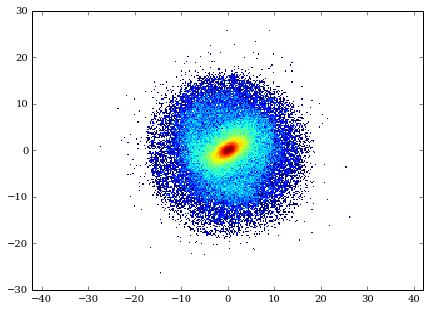

In [101]:
figsize(7, 5)
HR = hist2d(F_Xc, F_Yc, bins=200, norm=mpl.colors.LogNorm())
axis('equal')

In [102]:
rot_curve_d = loadtxt('../data/MW_models/rc-test/rotcurve.txt', skiprows=1)
r = rot_curve_d[:,0] / 0.7
vcd = rot_curve_d[:,3]

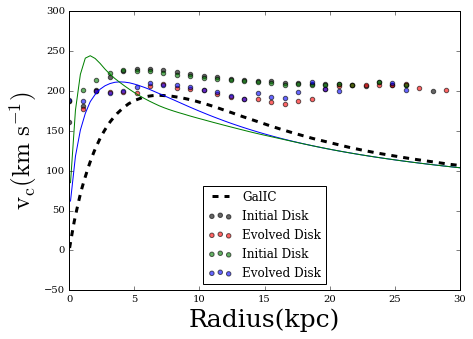

In [111]:
RI, VI = rot_curve1(I_Xc, I_Yc, I_Zc, I_Vxc, I_Vyc, I_Vzc)
RF, VF = rot_curve1(F_Xc, F_Yc, F_Zc, F_Vxc, F_Vyc, I_Vzc)

RI2, VI2 = rot_curve2(I_Xc, I_Yc, I_Zc, I_Vxc, I_Vyc, I_Vzc)
RF2, VF2 = rot_curve2(F_Xc, F_Yc, F_Zc, F_Vxc, F_Vyc, I_Vzc)



scatter(RI[:-1], VI[:-1], s=20, c='k', alpha=0.6, label='Initial Disk')
scatter(RF[:-1], VF[:-1], s=20, c='r', alpha=0.6, label='Evolved Disk')

scatter(RI2[:-1], VI2[:-1], s=20, c='g', alpha=0.6, label='Initial Disk')
scatter(RF2[:-1], VF2[:-1], s=20, c='b', alpha=0.6, label='Evolved Disk')

plot(r, vcd, lw=3, c='k', ls='--', label='GalIC')
plot(R2I, VC2I)
plot(R2F, VC2F)
legend(loc='lower center')
xlim(0, 30)
xlabel('Radius(kpc)', fontsize=25)
ylabel('$\mathrm{v_c(km\ s^{-1}})$', fontsize=25)
savefig('Disk_rotcurve.png')